In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Data preprocessing

In [3]:
df= pd.read_csv("spam 2.csv")

In [4]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.describe()

,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
df.columns = ['label', 'message']

In [7]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df['label'] = df['label'].map({"ham": 0, "spam": 1})

(np.float64(-1.0999999238593192),
 np.float64(1.0999999963742533),
 np.float64(-1.0999999690505617),
 np.float64(1.099999832132587))

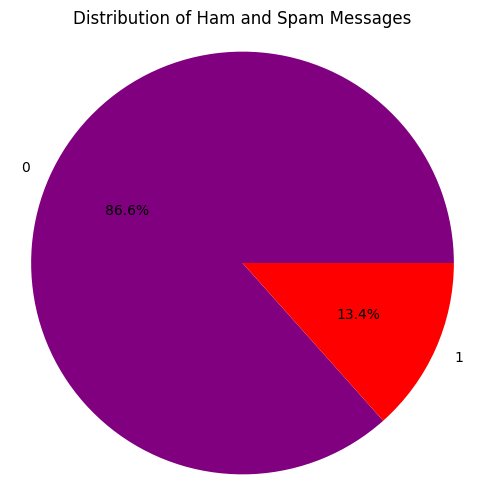

In [9]:
labels = ['0', '1']
sizes = df['label'].value_counts().sort_index()
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=0, colors=['purple', 'red'])
plt.title('Distribution of Ham and Spam Messages')
plt.axis('equal') 

In [12]:
df

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


# Data is imbalanced

In [13]:
stop_words = set(stopwords.words("English"))

In [14]:
def clean_text(text):
    text= text.lower()
    text = re.sub(r'\W', ' ', text)                  # 2. Remove punctuation
    text = re.sub(r'\d+', '', text)                  # 3. Remove numbers
    text = text.split()
    text = [word for word in text if word not in stop_words]  # 5. Remove stopwords
    return " ".join(text)

In [15]:
df["cleaned_message"]= df["message"].apply(clean_text)

In [16]:
df

,label,message,cleaned_message
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,nd time tried contact u u pound prize claim ea...
5568,0,Will ü b going to esplanade fr home?,ü b going esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",pity mood suggestions
5570,0,The guy did some bitching but I acted like i'd...,guy bitching acted like interested buying some...


In [17]:
# nltk.download('wordnet')
# nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/new/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/new/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [18]:
lemmatizer = WordNetLemmatizer()

In [19]:
def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [20]:
df['lemmatized_message'] = df['cleaned_message'].apply(lemmatize_text)

In [21]:
df

,label,message,cleaned_message,lemmatized_message
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...,go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though,nah think go usf life around though
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,nd time tried contact u u pound prize claim ea...,nd time tried contact u u pound prize claim ea...
5568,0,Will ü b going to esplanade fr home?,ü b going esplanade fr home,ü b going esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",pity mood suggestions,pity mood suggestion
5570,0,The guy did some bitching but I acted like i'd...,guy bitching acted like interested buying some...,guy bitching acted like interested buying some...


In [22]:
df2= df[["label", "cleaned_message"]]

In [25]:
df= df.drop( "message", axis = 1)

In [26]:
df

,label,lemmatized_message
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry wkly comp win fa cup final tkts st ...
3,0,u dun say early hor u c already say
4,0,nah think go usf life around though
...,...,...
5567,1,nd time tried contact u u pound prize claim ea...
5568,0,ü b going esplanade fr home
5569,0,pity mood suggestion
5570,0,guy bitching acted like interested buying some...


# Data Vectorization 

In [27]:
tfidf = TfidfVectorizer()

In [28]:
X = tfidf.fit_transform(df['lemmatized_message'])

In [29]:
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 45003 stored elements and shape (5572, 7162)>

In [30]:
y= df["label"]

# Machine Learning 

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
model = LogisticRegression(max_iter=1000)

In [34]:
from sklearn.metrics import accuracy_score, classification_report

In [35]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [36]:
y_pred= model.predict(X_test)

In [37]:
# accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [38]:
accuracy_score(y_test, y_pred)

0.9614349775784753

In [39]:
precision_score(y_test, y_pred)

0.9907407407407407

In [40]:
recall_score(y_test, y_pred)

0.7181208053691275

In [41]:
f1_score(y_test, y_pred)

0.8326848249027238

In [42]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[965,   1],
       [ 42, 107]])

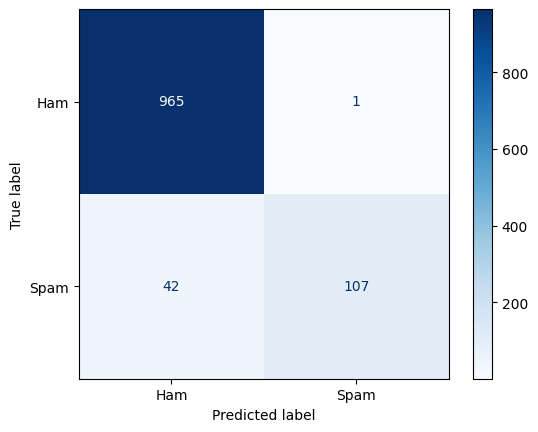

In [43]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap=plt.cm.Blues)

# Now we can clearly see that, our data is overtrained on the Ham

In [46]:
smote = SMOTE()

In [48]:
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [49]:
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_resampled, y_resampled)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [50]:
y_pred= model.predict(X_test)

In [51]:
accuracy_score(y_test, y_pred)

0.97847533632287

In [52]:
precision_score(y_test, y_pred)

0.9370629370629371

In [53]:
recall_score(y_test, y_pred)

0.8993288590604027

In [54]:
f1_score(y_test, y_pred)

0.9178082191780822

In [55]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[957,   9],
       [ 15, 134]])

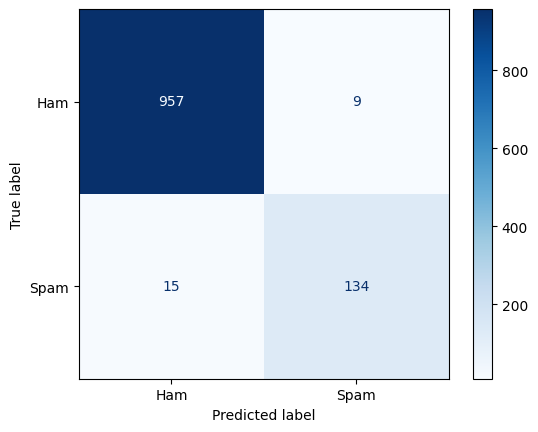

In [56]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap=plt.cm.Blues)

# Final Pipeline

In [68]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # If input is a list (like in prediction), convert to Series
        if isinstance(X, list):
            X = pd.Series(X)

        return X.apply(self.clean_and_lemmatize)

    def clean_and_lemmatize(self, text):
        text = text.lower()
        text = re.sub(r'\W', ' ', text)
        text = re.sub(r'\d+', '', text)
        text = text.split()
        text = [word for word in text if word not in stop_words]
        text = [lemmatizer.lemmatize(word) for word in text]
        return " ".join(text)


In [69]:
final_pipeline = Pipeline([
    ('preprocessor', TextPreprocessor()),  # Cleans and lemmatizes
    ('vectorizer', tfidf),                 # Use the already-fitted vectorizer
    ('classifier', model)                  # Use the trained model
])

# Prediction's

In [70]:
def predict_spam(message):
    result = final_pipeline.predict([message])[0]
    return "Spam" if result == 1 else "Ham"

In [72]:
print(predict_spam("Congratulations! You've won a free ticket. Call now!"))

Spam


In [73]:
print(predict_spam("Hey, are we still meeting for lunch today?"))


Ham


In [75]:
messages = [
    "Can we meet tomorrow for the project discussion?",
    "You have been selected for a $1000 prize. Click the link!",
    "Don’t forget our appointment next week."
]

for msg in messages:
    print(f"{msg} --> {predict_spam(msg)}")


Can we meet tomorrow for the project discussion? --> Ham
You have been selected for a $1000 prize. Click the link! --> Spam
Don’t forget our appointment next week. --> Ham


In [77]:
joblib.dump(final_pipeline, "spam_classifier_pipeline.pkl")


['spam_classifier_pipeline.pkl']

In [78]:
final_pipeline = joblib.load("spam_classifier_pipeline.pkl")